In [36]:
import evaluate
import numpy as np
import pandas as pd
import re
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import softmax
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from datasets import Dataset
from transformers import AutoTokenizer, get_scheduler, AutoModelForSequenceClassification
from tqdm.auto import tqdm
import fasttext.util

RANDOM_STATE = 42

In [4]:
df = pd.read_csv("processed.csv")
df.head()

,text,is_quote_status,has_card,1_day_after,is_in_reply_to,is_urls,is_thumbnail_title,is_hashtags,year,month,day_of_week
0,metatckr zuckerberg has said that they would b...,0,0,0,0,0,0,0,2024,10,5
1,"you can follow all market news, including for ...",0,0,1,1,1,0,0,2024,9,5
2,just in: apple aapltckr is now reportedly no l...,0,0,1,0,0,0,0,2024,9,5
3,"apple, aapltckr, is no longer a ‘growth engine...",0,0,1,0,0,0,0,2024,9,3
4,here are the hottest and most active bullish a...,0,0,1,0,1,0,0,2024,9,0


In [5]:
df = df[["text", "1_day_after"]].rename({"1_day_after": "label"}, axis=1)

X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
Xtrain, Xval = train_test_split(X_train, test_size=0.2, random_state=RANDOM_STATE)

train = Dataset.from_pandas(Xtrain)
val = Dataset.from_pandas(Xval)

train = train.remove_columns(["__index_level_0__"])
val = val.remove_columns(["__index_level_0__"])

In [23]:
fasttext.util.download_model('en', if_exists='ignore')
ft_model = fasttext.load_model('cc.en.300.bin')

In [25]:
def text_to_vec(text, model, dim=300):
    words = text
    vectors = [model[word] for word in words if word in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

def vectorize_dataframe(df, model, dim=300):
    return np.vstack(df["text"].apply(lambda x: text_to_vec(str(x), model, dim)).values)

In [27]:
X_train_vec = vectorize_dataframe(Xtrain, ft_model)
X_val_vec   = vectorize_dataframe(Xval, ft_model)
X_test_vec  = vectorize_dataframe(X_test, ft_model)

y_train = Xtrain["label"].values
y_val   = Xval["label"].values
y_test  = X_test["label"].values

In [28]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_vec, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [34]:
#валидация
y_val_pred = model_xgb.predict(X_val_vec)
y_val_proba = model_xgb.predict_proba(X_val_vec)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_proba)

print(f"ROC-AUC: {roc_auc:.4f}")
print("Validation performance:")
print(classification_report(y_val, y_val_pred))

ROC-AUC: 0.5339
Validation performance:
              precision    recall  f1-score   support

           0       0.47      0.44      0.45       611
           1       0.55      0.58      0.57       733

    accuracy                           0.52      1344
   macro avg       0.51      0.51      0.51      1344
weighted avg       0.51      0.52      0.52      1344



In [35]:
#на тесте
y_test_pred = model_xgb.predict(X_test_vec)
y_test_proba = model_xgb.predict_proba(X_test_vec)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"ROC-AUC: {roc_auc:.4f}")
print("Validation performance:")
print(classification_report(y_test, y_test_pred))

ROC-AUC: 0.5883
Validation performance:
              precision    recall  f1-score   support

           0       0.54      0.50      0.52       800
           1       0.57      0.61      0.59       880

    accuracy                           0.56      1680
   macro avg       0.55      0.55      0.55      1680
weighted avg       0.56      0.56      0.56      1680



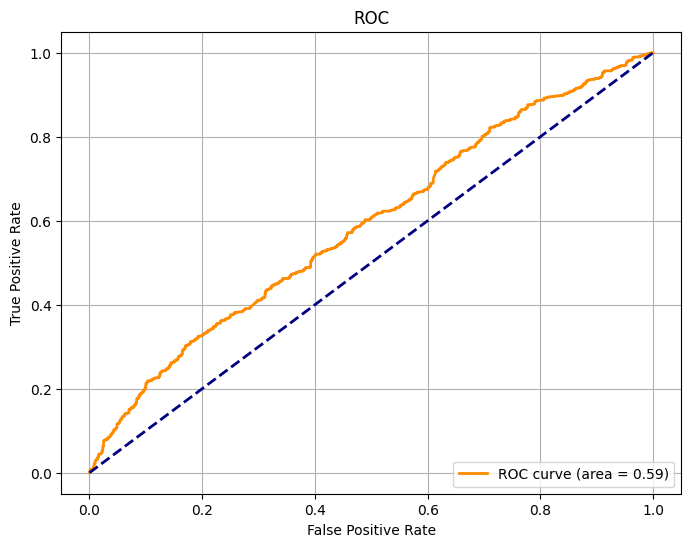

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()